# Predict the rift

Imports necesarios

In [1]:
import time
from IPython.display import clear_output
import plotly.graph_objects as go
import pandas as pd
import requests
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate,cross_val_predict, cross_val_score
from sklearn import svm
import seaborn as sns
from matplotlib import pyplot

Api key que se utilizara para hacer las requests necesarias

In [51]:
gameid = "EUW1_5921666749"
api_key = "RGAPI-a8585106-4f99-4026-aa58-278a3c468d06"

Carga de datos y exploración inicial

In [3]:
df = pd.read_pickle("finalinfo.pkl")
df_winners = df[df["BlueWin"] == True]
df_losers = df[df["BlueWin"] == False]

Leyenda datos:

* kd + n = Diferencia de kills entre los 2 equipos
* gd + n = Diferencia de oro entre los 2 equipos
* xpd + n = Diferencia de experiencia total entre los 2 equipos
* csd + n = Diferencia de minions total entre los 2 equipos
* dd + n = Diferencia de dragones entre los 2 equipos
* hd + n = Diferencia de heraldos entre los 2 equipos
* td + n = Diferencia de torres destruidas entre los 2 equipos
* pd + n = Diferencia de placas destruidas entre los 2 equipos
* tdd + n = Diferencia de daño total entre los 2 equipos
* wd + n = Diferencia de wards puestos entre los 2 equipos
* BlueWin = Boolean sobre la victoria del equipo azul

In [4]:
df.head()

temp_names,gd1,gd10,gd11,gd12,gd13,gd14,gd15,gd2,gd3,gd4,...,wd7,wd8,wd9,wd10,wd11,wd12,wd13,wd14,wd15,BlueWin
gameId,,,,,,,,,,,,,,,,,,,,,
EUW1_5763325310,516,16400,23181,30858,39067,49680,61268,1109,1774,3458,...,5,11,12,16,15,24,28,30,36,True
EUW1_5763410685,500,5005,5207,5813,6097,6703,7860,974,1228,1073,...,65,66,70,73,86,91,119,136,145,True
EUW1_5763819470,559,-2886,-4284,-6152,-6830,-8325,-8928,1097,1600,1046,...,19,24,28,30,37,41,48,50,54,True
EUW1_5764707648,0,-5689,-6628,-9264,-12651,-17040,-21966,162,-368,-1060,...,-7,-7,-7,-7,-9,-10,-9,-13,-13,False
EUW1_5765338010,0,8681,10020,11340,12929,14682,16479,-57,416,1796,...,3,7,4,4,1,2,1,0,1,True


In [5]:
df.describe()

temp_names,kd1,kd2,kd3,kd4,kd5,kd6,kd7,kd8,kd9,kd10,...,wd6,wd7,wd8,wd9,wd10,wd11,wd12,wd13,wd14,wd15
count,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.00000,3964.000000,...,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000,3964.000000
mean,0.006559,0.003532,0.023713,0.017659,0.041120,0.053734,0.038093,0.068365,0.04894,0.041120,...,0.389506,0.559031,0.729818,0.784813,0.892533,1.029516,1.118315,1.246973,1.402371,1.399344
std,0.284971,0.580608,1.031643,1.612214,2.044687,2.467736,2.977807,3.432727,3.87694,4.390315,...,9.623687,11.655359,13.962601,15.977996,18.226310,20.581672,23.009162,25.481966,28.210347,30.564348
min,-2.000000,-4.000000,-6.000000,-7.000000,-9.000000,-11.000000,-11.000000,-15.000000,-15.00000,-18.000000,...,-110.000000,-147.000000,-153.000000,-196.000000,-213.000000,-243.000000,-275.000000,-293.000000,-320.000000,-374.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000,-2.000000,-2.000000,-2.000000,-3.00000,-3.000000,...,-2.000000,-2.000000,-3.000000,-3.000000,-4.000000,-4.000000,-5.000000,-6.000000,-6.000000,-7.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,2.000000,3.00000,3.000000,...,2.000000,3.000000,3.000000,4.000000,5.000000,5.000000,6.000000,7.000000,8.000000,9.000000
max,3.000000,4.000000,5.000000,7.000000,7.000000,8.000000,11.000000,12.000000,15.00000,18.000000,...,148.000000,172.000000,219.000000,221.000000,226.000000,249.000000,271.000000,292.000000,341.000000,368.000000


Comprobar si las clases están repartidas equitativamente

In [6]:
print("% rows que son victoria: "+ str((len(df[df["BlueWin"] == True])/len(df)*100)))
print(" ")
print("% rows que son derrota: "+ str((len(df[df["BlueWin"] == False])/len(df)*100)))

% rows que son victoria: 49.59636730575176
 
% rows que son derrota: 50.40363269424824


Exploración visual basica

La relación más importante de los datos es la que hay entre la diferencia de oro y la diferencia de kills, ya que son directamente proporcionales.

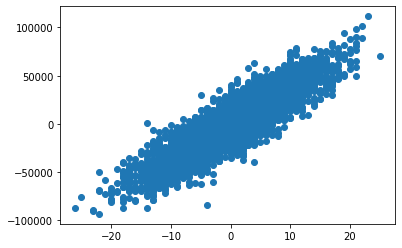

In [7]:
plt.scatter(df["kd15"],df["gd15"])

La duración media de una partida es de 25-30 minutos, pero a pesar de contar con datos hasta el minuto 15, podemos observar como hay una clara tendencia a que el ganador de la partida es el que tiene mayor diferencia de oro.

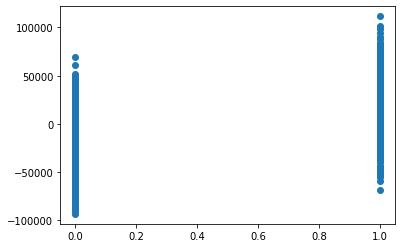

In [8]:
plt.scatter(df["BlueWin"],df["gd15"])

Separamos en test y train sets

In [68]:
X_train = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
X_test = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
y_train = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
y_test = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

y = df["BlueWin"]
for i in range(1,16):
    X = df[["kd"+str(i)+"","gd"+str(i)+"","xpd"+str(i)+"","csd"+str(i)+"","dd"+str(i)+"","hd"+str(i)+"","td"+str(i)+"","pd"+str(i)+"","tdd"+str(i)+"","wd"+str(i)+""]]
    X_train[i-1], X_test[i-1], y_train[i-1], y_test[i-1] = train_test_split(X,y)

# Logistic Regression

In [69]:
lr_score = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# define the model
lr = LogisticRegression()

for i in range(0,15):
    scores = cross_validate(lr,X_train[i],y_train[i],cv=10)
    lr_score[i] = sum(scores['test_score'])/10

In [70]:
lr_score

[0.5072413169728606,
 0.521008745169819,
 0.5607416446342621,
 0.6094920118410052,
 0.6363907531692765,
 0.648841886425779,
 0.6700336700336701,
 0.6794398119901477,
 0.7003050640634533,
 0.7063690597247644,
 0.7191342959799336,
 0.7363060131516508,
 0.7302454070910447,
 0.7584830406978058,
 0.7753203172666261]

In [71]:
avg_lr = sum(lr_score)/15
avg_lr

0.66395686921414

# Decision Trees

In [72]:
dt_score = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# define the model
dt = DecisionTreeClassifier()

for i in range(0,15):
    scores = cross_validate(dt,X_train[i],y_train[i],cv=10)
    dt_score[i] = sum(scores['test_score'])/10

In [73]:
dt_score

[0.5082627166519784,
 0.5119438230176485,
 0.5152848394459133,
 0.5411892979007074,
 0.5465866720900279,
 0.5523230063498519,
 0.5738390617585248,
 0.5913271416627122,
 0.6071079926784625,
 0.6057962172056133,
 0.6215748084875602,
 0.6300149142431022,
 0.6424479696291776,
 0.6498406887668633,
 0.6757835626963143]

In [74]:
avg_dt = sum(dt_score)/15
avg_dt

0.5848881808389639

# Random Forest

In [75]:
rf_score = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# define the model
rf = RandomForestClassifier(oob_score=True)

for i in range(0,15):
    scores = cross_validate(rf,X_train[i],y_train[i],cv=10)
    rf_score[i] = sum(scores['test_score'])/10

In [76]:
rf_score

[0.4971640340767857,
 0.5297640837909294,
 0.5213736921790614,
 0.5785472171378212,
 0.6276614014869049,
 0.620251734345694,
 0.646814905204167,
 0.6606094502067656,
 0.6824712448873523,
 0.6845083949110794,
 0.7053431405780399,
 0.719143334915147,
 0.7258841208505639,
 0.7413474792669423,
 0.7675852484577317]

In [77]:
avg_rf = sum(rf_score)/15
avg_rf

0.6472312988196656

# Artificial Neural Networks

In [78]:
clf_score = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# define the model
clf = MLPClassifier()

for i in range(0,15):
    scores = cross_validate(clf,X_train[i],y_train[i],cv=10)
    clf_score[i] = sum(scores['test_score'])/10

In [79]:
clf_score

[0.49882267868845054,
 0.5085485729781032,
 0.47861274941811854,
 0.5280726730391161,
 0.5570096942580164,
 0.5509705556685423,
 0.5536472103586197,
 0.5950093778952839,
 0.6283020360201568,
 0.5795347208098887,
 0.6108184755835763,
 0.6175570017851897,
 0.693238876460353,
 0.6659864867918559,
 0.705022258377963]

In [80]:
avg_clf = sum(clf_score)/15
avg_clf

0.584743557875549

# SVM

In [81]:
svm_score = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# define the model
svmcl =  svm.SVC()

for i in range(0,15):
    scores = cross_validate(svmcl,X_train[i],y_train[i],cv=10)
    svm_score[i] = sum(scores['test_score'])/10

In [82]:
svm_score

[0.510267100535557,
 0.5206697850993154,
 0.5600592050256481,
 0.6047838564617088,
 0.6306781461143878,
 0.6488407565588774,
 0.6626330418276727,
 0.6703613314351571,
 0.6865116489277563,
 0.6935778365308567,
 0.7026495378844372,
 0.7248615913045444,
 0.7275563238650488,
 0.734956952071046,
 0.7561532551465439]

In [83]:
avg_svm = sum(svm_score)/15
avg_svm

0.6556373579192373

# LightGBM

In [25]:
lgb.LGBMClassifier?

In [84]:
lgbm_score = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
lgbm_score_test = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# define the model
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=50,max_depth=5,is_unbalance=False)

for i in range(0,15):
    X_train[i]["gd"+str(i+1)] = X_train[i]["gd"+str(i+1)].astype('int32')
    X_test[i]["gd"+str(i+1)] = X_test[i]["gd"+str(i+1)].astype('int32')
    scores = cross_validate(lgbm_model,X_train[i],y_train[i],cv=10)
    scores_test = cross_validate(lgbm_model,X_test[i],y_test[i],cv=10)
    lgbm_score[i] = sum(scores['test_score'])/10
    lgbm_score_test[i] = sum(scores_test['test_score'])/10

In [85]:
lgbm_score

[0.49344790183716364,
 0.5196755022258379,
 0.5247248774094412,
 0.5781992181321042,
 0.6202404356766774,
 0.6246265789889951,
 0.6474950850789778,
 0.6454794025263823,
 0.6821435834858652,
 0.6828248932275777,
 0.7090344157458252,
 0.7090423248141369,
 0.7181422728402596,
 0.73898379770863,
 0.7655684360382347]

In [86]:
lgbm_score_test

[0.4923838383838384,
 0.4954141414141414,
 0.5458585858585859,
 0.5438989898989899,
 0.5832424242424242,
 0.6125454545454546,
 0.6215757575757576,
 0.6185757575757577,
 0.6337777777777778,
 0.7083232323232324,
 0.7063636363636364,
 0.6670303030303031,
 0.7245555555555555,
 0.7426363636363637,
 0.7133838383838383]

In [87]:
avg_lgbm = sum(lgbm_score)/15
avg_lgbm

0.6439752483824072

----------------------------------------------------------------

Comparamos los resultados del cross validation para comparar entre los distintos modelos

En cuanto al score global, podemos ver que los resultados son parecidos entre los modelos ya que en los primeros minutos predecir el resultado es un 50/50 en todos los modelos.

<BarContainer object of 6 artists>

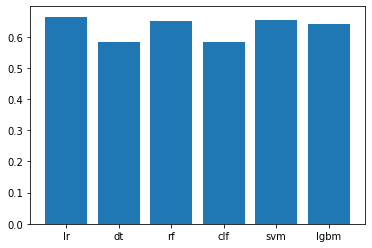

In [30]:
plt.bar(["lr","dt","rf","clf","svm","lgbm"],[avg_lr,avg_dt,avg_rf,avg_clf,avg_svm,avg_lgbm])

Haciendo la media del minuto 10 al 15, sigue sucediendo lo mismo pero como anteriormente pasaba, Logistic Regression, Random forest y SVM parecen ser los modelos con mayor poder de predicción. Aunque nunca llegan al 80%.

In [31]:
scores15_lr = 0
scores15_dt = 0
scores15_rf = 0
scores15_clf = 0
scores15_svm = 0
scores15_lgbm = 0

for i in range(1,6):
    scores15_lr = lr_score[9+i] + scores15_lr
    scores15_dt = dt_score[9+i] + scores15_dt
    scores15_rf = rf_score[9+i] + scores15_rf
    scores15_clf = clf_score[9+i] + scores15_clf
    scores15_svm = svm_score[9+i] + scores15_svm
    scores15_lgbm = svm_score[9+i] + scores15_lgbm
    
avgsc15_lr = scores15_lr/5
avgsc15_dt = scores15_dt/5
avgsc15_rf = scores15_rf/5
avgsc15_clf = scores15_clf/5
avgsc15_svm = scores15_svm/5
avgsc15_lgbm = scores15_lgbm/5

In [32]:
scores15_lr

3.7016642939461732

<BarContainer object of 6 artists>

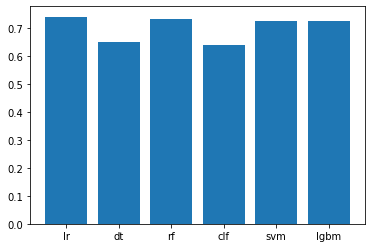

In [33]:
plt.bar(["lr","dt","rf","clf","svm","lgbm"],[avgsc15_lr,avgsc15_dt,avgsc15_rf,avgsc15_clf,avgsc15_svm,avgsc15_lgbm])

----------------------------------------------------------------

# Predict the rift (Logistic Regression)

Importancia de las features

Global (minuto 0-15)

In [34]:
y = df["BlueWin"]

lr = LogisticRegression()

for i in range(1,16):
    
    X = df[["kd"+str(i)+"","gd"+str(i)+"","xpd"+str(i)+"","csd"+str(i)+"","dd"+str(i)+"","hd"+str(i)+"","td"+str(i)+"","pd"+str(i)+"","tdd"+str(i)+"","wd"+str(i)+""]]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    lr.fit(X_train, y_train)
    
    if i == 1:
        importance = lr.coef_[0]
    else:
        importance = importance + lr.coef_[0]


c:\users\mario\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\mario\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [35]:
fix_importance = importance/15

Feature: kd, Score: 0.13358
Feature: gd, Score: 0.00009
Feature: xpd, Score: 0.00078
Feature: csd, Score: -0.04423
Feature: dd, Score: 0.05541
Feature: hd, Score: 0.00259
Feature: td, Score: 0.00533
Feature: pd, Score: 0.04845
Feature: tdd, Score: -0.00000
Feature: wd, Score: 0.00077


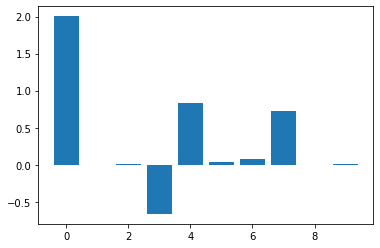

In [36]:
# summarize feature importance
for i,v in enumerate(fix_importance):
    print('Feature: '+X.axes[1][i][:-2]+', Score: %.5f' % (v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Antes del primer dragón (minuto 0-5)

In [37]:
y = df["BlueWin"]

lr = LogisticRegression()

for i in range(1,6):
    
    X = df[["kd"+str(i)+"","gd"+str(i)+"","xpd"+str(i)+"","csd"+str(i)+"","dd"+str(i)+"","hd"+str(i)+"","td"+str(i)+"","pd"+str(i)+"","tdd"+str(i)+"","wd"+str(i)+""]]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    lr.fit(X_train, y_train)
    
    if i == 1:
        importance = lr.coef_[0]
    else:
        importance = importance + lr.coef_[0]


c:\users\mario\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
fix_importance = importance/5

Feature: kd, Score: 0.26183
Feature: gd, Score: 0.00006
Feature: xpd, Score: 0.00029
Feature: csd, Score: -0.06431
Feature: dd, Score: 0.00000
Feature: hd, Score: 0.00000
Feature: td, Score: 0.00000
Feature: pd, Score: -0.00156
Feature: tdd, Score: 0.00002
Feature: wd, Score: 0.00597


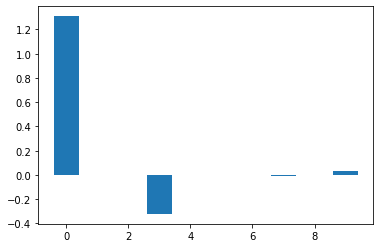

In [39]:
# summarize feature importance
for i,v in enumerate(fix_importance):
    print('Feature: '+X.axes[1][i][:-1]+', Score: %.5f' % (v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Desde el primer dragón (minuto 5-15)

In [40]:
y = df["BlueWin"]

lr = LogisticRegression()

for i in range(5,16):
    
    X = df[["kd"+str(i)+"","gd"+str(i)+"","xpd"+str(i)+"","csd"+str(i)+"","dd"+str(i)+"","hd"+str(i)+"","td"+str(i)+"","pd"+str(i)+"","tdd"+str(i)+"","wd"+str(i)+""]]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    lr.fit(X_train, y_train)
    
    if i == 5:
        importance = lr.coef_[0]
    else:
        importance = importance + lr.coef_[0]


c:\users\mario\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
fix_importance = importance/11

Feature: kd, Score: 0.08422
Feature: gd, Score: 0.00007
Feature: xpd, Score: 0.00006
Feature: csd, Score: -0.00013
Feature: dd, Score: 0.03085
Feature: hd, Score: 0.00049
Feature: td, Score: 0.00026
Feature: pd, Score: 0.03820
Feature: tdd, Score: -0.00001
Feature: wd, Score: -0.00043


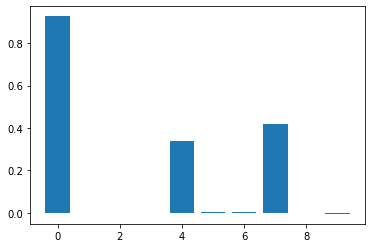

In [42]:
# summarize feature importance
for i,v in enumerate(fix_importance):
    print('Feature: '+X.axes[1][i][:-2]+', Score: %.5f' % (v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

Desde el primer heraldo (minuto 8-15)

In [43]:
y = df["BlueWin"]

lr = LogisticRegression()

for i in range(8,16):
    X = df[["kd"+str(i)+"","gd"+str(i)+"","xpd"+str(i)+"","csd"+str(i)+"","dd"+str(i)+"","hd"+str(i)+"","td"+str(i)+"","pd"+str(i)+"","tdd"+str(i)+"","wd"+str(i)+""]]
    
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    lr.fit(X_train, y_train)
    
    if i == 8:
        importance = lr.coef_[0]
    else:
        importance = importance + lr.coef_[0]

c:\users\mario\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\mario\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [44]:
fix_importance = importance/8

Feature: kd, Score: 0.15900
Feature: gd, Score: 0.00001
Feature: xpd, Score: 0.00003
Feature: csd, Score: 0.00004
Feature: dd, Score: 0.06734
Feature: hd, Score: 0.00309
Feature: td, Score: 0.01356
Feature: pd, Score: 0.10595
Feature: tdd, Score: -0.00001
Feature: wd, Score: -0.00002


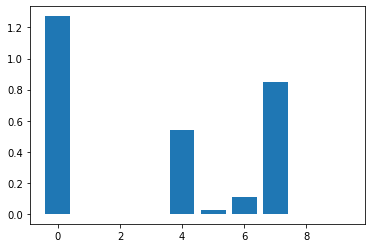

In [45]:
# summarize feature importance
for i,v in enumerate(fix_importance):
    print('Feature: '+X.axes[1][i][:-2]+', Score: %.5f' % (v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

-------------------------------------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------------------

Añadiendo el data de la partida para poder predecir el resultado

In [52]:
data = {}
kills = 0;ekills = 0
gold = 0;egold = 0
xp = 0;exp = 0
cs = 0;ecs = 0
drakes = 0;edrakes = 0
heralds = 0;eheralds = 0
towers = 0;etowers = 0
plates = 0;eplates= 0
dmg = 0;edmg = 0
wards = 0;ewards = 0

response = requests.get("https://europe.api.riotgames.com/lol/match/v5/matches/"+gameid+"/timeline?api_key="+api_key+"").json()
        
#First 15min loop                                
for j in range(1,16):

    #Events loop
    for k in range(0,len(response["info"]["frames"][j]["events"])):

        #KillsDiff
        if response["info"]["frames"][j]["events"][k]["type"] == "CHAMPION_KILL":
            if response["info"]["frames"][j]["events"][k]["killerId"] <= 5:
                kills += 1
            else:
                ekills += 1 

        #DrakesDiff & HeraldsDiff
        if response["info"]["frames"][j]["events"][k]["type"] == "ELITE_MONSTER_KILL":
            if response["info"]["frames"][j]["events"][k]["monsterType"] == "DRAGON": 
                if response["info"]["frames"][j]["events"][k]["killerId"] <= 5:
                    drakes += 1
                else:
                    edrakes += 1 

            elif response["info"]["frames"][j]["events"][k]["monsterType"] == "RIFTHERALD":
                if response["info"]["frames"][j]["events"][k]["killerId"] <= 5:
                    heralds += 1
                else:
                    eheralds += 1

        #TowersDiff
        if response["info"]["frames"][j]["events"][k]["type"] == "BUILDING_KILL":
            if response["info"]["frames"][j]["events"][k]["buildingType"] == "TOWER_BUILDING":
                if response["info"]["frames"][j]["events"][k]["teamId"] == 200:
                    towers += 1
                else:
                    etowers += 1

        #PlatesDiff
        if response["info"]["frames"][j]["events"][k]["type"] == "TURRET_PLATE_DESTROYED":
            if response["info"]["frames"][j]["events"][k]["teamId"] == 200:
                plates += 1
            else:
                eplates += 1

        #WardsDiff
        if response["info"]["frames"][j]["events"][k]["type"] == "WARD_PLACED":
            if response["info"]["frames"][j]["events"][k]["creatorId"] <= 5:
                wards += 1
            else:
                ewards += 1


    #Players Loop
    for k in range(1,11):

        #GoldDiff
        if k <= 5:
            gold += response["info"]["frames"][j]["participantFrames"][str(k)]["totalGold"]
        else:
            egold += response["info"]["frames"][j]["participantFrames"][str(k)]["totalGold"]

        #XpDiff
        if k <= 5:
            xp += response["info"]["frames"][j]["participantFrames"][str(k)]["xp"]
        else:
            exp += response["info"]["frames"][j]["participantFrames"][str(k)]["xp"]  

        #CsDiff
        if k <= 5:
            cs += response["info"]["frames"][j]["participantFrames"][str(k)]["minionsKilled"] + response["info"]["frames"][j]["participantFrames"][str(k)]["jungleMinionsKilled"]
        else:
            ecs += response["info"]["frames"][j]["participantFrames"][str(k)]["minionsKilled"] + response["info"]["frames"][j]["participantFrames"][str(k)]["jungleMinionsKilled"]

        #DmgDiff
        if k <= 5:
            dmg += response["info"]["frames"][j]["participantFrames"][str(k)]["damageStats"]["totalDamageDoneToChampions"]
        else:
            edmg += response["info"]["frames"][j]["participantFrames"][str(k)]["damageStats"]["totalDamageDoneToChampions"]


    #Final append to dict
    data["kd"+str(j)+""] = [kills - ekills]
    data["gd"+str(j)+""] = [gold - egold]
    data["xpd"+str(j)+""] = [xp - exp]
    data["csd"+str(j)+""] = [cs - ecs]
    data["dd"+str(j)+""] =[drakes - edrakes]
    data["hd"+str(j)+""] = [heralds - eheralds]
    data["td"+str(j)+""] = [towers - etowers]
    data["pd"+str(j)+""] = [plates - eplates]
    data["tdd"+str(j)+""] = [dmg - edmg]
    data["wd"+str(j)+""] = [wards - ewards]
    
    kills = 0;ekills = 0
    gold = 0;egold = 0
    xp = 0;exp = 0
    cs = 0;ecs = 0
    drakes = 0;edrakes = 0
    heralds = 0;eheralds = 0
    towers = 0;etowers = 0
    plates = 0;eplates= 0
    dmg = 0;edmg = 0
    wards = 0;ewards = 0
    
for k in range(0,len(response["info"]["frames"][len(response["info"]["frames"])-1]["events"])):
        if response["info"]["frames"][len(response["info"]["frames"])-1]["events"][k]["type"] == "GAME_END":
            if response["info"]["frames"][len(response["info"]["frames"])-1]["events"][k]["winningTeam"] == 100:
                data["BlueWin"] = True
            else:
                data["BlueWin"] = False 
    
data["gameId"] = [gameid]

df_temp = pd.DataFrame(data)
df_temp.set_index('gameId') 

,kd1,gd1,xpd1,csd1,dd1,hd1,td1,pd1,tdd1,wd1,...,gd15,xpd15,csd15,dd15,hd15,td15,pd15,tdd15,wd15,BlueWin
gameId,,,,,,,,,,,,,,,,,,,,,
EUW1_5921666749,0,0,0,0,0,0,0,0,0,2,...,2563,1124,26,-1,1,-1,0,8791,8,True


In [63]:
lgb.LGBMClassifier?

In [88]:
import warnings
warnings.filterwarnings('ignore')
lgbm_model = lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=50,max_depth=5,is_unbalance=False)
winner_team = []
probs = []
for i in range(1,16):
    X = df[["kd"+str(i)+"","gd"+str(i)+"","xpd"+str(i)+"","csd"+str(i)+"","dd"+str(i)+"","hd"+str(i)+"","td"+str(i)+"","pd"+str(i)+"","tdd"+str(i)+"","wd"+str(i)+""]]
    X["gd"+str(i)] = X["gd"+str(i)].astype('int32')
    lgbm_model.fit(X, y)
    Xnew = df_temp[["kd"+str(i)+"","gd"+str(i)+"","xpd"+str(i)+"","csd"+str(i)+"","dd"+str(i)+"","hd"+str(i)+"","td"+str(i)+"","pd"+str(i)+"","tdd"+str(i)+"","wd"+str(i)+""]]
    Xnew["gd"+str(i)] = Xnew["gd"+str(i)].astype('int32')
    if lgbm_model.predict_proba(Xnew)[0][1] > lgbm_model.predict_proba(Xnew)[0][0]:
        probs.append(lgbm_model.predict_proba(Xnew)[0])
        winner_team.append("Blue Team")
    else:
        probs.append(lgbm_model.predict_proba(Xnew)[0])
        winner_team.append("Red Team")
    print(lgbm_model.predict_proba(Xnew)[0])

[0.48450399 0.51549601]
[0.34422668 0.65577332]
[0.41051082 0.58948918]
[0.4504728 0.5495272]
[0.34942721 0.65057279]
[0.468388 0.531612]
[0.40540826 0.59459174]
[0.39888559 0.60111441]
[0.51742087 0.48257913]
[0.56961082 0.43038918]
[0.34628958 0.65371042]
[0.41741552 0.58258448]
[0.40453571 0.59546429]
[0.43095033 0.56904967]
[0.7335603 0.2664397]


# Visualización

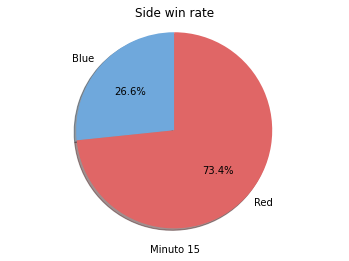

In [89]:
labels = ['Blue', 'Red']

colores = ['#6fa8dc','#e06666']

for i in range(15):
    clear_output(wait=True)
    sizes = [(probs[i][1])*100, (probs[i][0])*100]
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels,colors=colores, autopct='%1.1f%%',shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title("Side win rate")
    plt.xlabel("Minuto "+str(i+1))
    plt.show()
    time.sleep(3)

In [49]:
plt.clf

<function matplotlib.pyplot.clf()>

In [90]:
quadrant_colors = ["#FFFFFF","#2bad4e", "#eff229", "#f25829"] 
quadrant_text = ["", "<b>Alta</b>", "<b>Media</b>","<b>Baja</b>"]
n_quadrants = len(quadrant_colors) - 1
min_value = 0
max_value = 100

for i in range(15):
    clear_output(wait=True)
    current_value = (probs[i][0])*100
    hand_length = np.sqrt(2) / 4
    hand_angle = np.pi * (1 - (max(min_value, min(max_value, current_value)) - min_value) / (max_value - min_value))

    fig = go.Figure(
        data=[
            go.Pie(
                values=[0.5] + (np.ones(n_quadrants) / 2 / n_quadrants).tolist(),
                rotation=90,
                hole=0.5,
                marker_colors=quadrant_colors,
                text=quadrant_text,
                textinfo="text",
                hoverinfo="skip",
            ),
        ],
        layout=go.Layout(
            showlegend=False,
            margin=dict(b=0,t=10,l=10,r=10),
            width=450,
            height=450,
            #paper_bgcolor=plot_bgcolor,
            annotations=[
                go.layout.Annotation(
                    text=f"<b>Probabilidad de victoria al min "+str(i)+":</b><br>"+str(round(current_value,0))+"%",
                    x=0.5, xanchor="center", xref="paper",
                    y=0.25, yanchor="bottom", yref="paper",
                    showarrow=False,
                )
            ],
            #Cursor del gráfico
            shapes=[
                go.layout.Shape(
                    type="circle",
                    x0=0.48, x1=0.52,
                    y0=0.48, y1=0.52,
                    fillcolor="#333",
                    line_color="#333",
                ),
                go.layout.Shape(
                    type="line",
                    x0=0.5, x1=0.5 + hand_length * np.cos(hand_angle),
                    y0=0.5, y1=0.5 + hand_length * np.sin(hand_angle),
                    line=dict(color="#333", width=4)
                )
            ]
        )
    )
    fig.show()
    time.sleep(3)